<a href="https://colab.research.google.com/github/sayan0506/Classify-Geometric-Images/blob/main/Deep_Learning_for_Geometric_Images_Classification_Keras_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning for Geometric Images Classification Keras implementation**

The task here is is to build a classifier that can classify for a given image as one of the 4 geometric data categories present in the dataset.  In order to train or test, we can consider all four categories with different orientations for training and inference. Detailed problem statement can be found [here](https://drive.google.com/drive/folders/12QAMwLlb_XglBFlvw7Q-CI1nNmMQW-D0?usp=sharing)

**Install Dependencies**

In [1]:
# install wandb
!pip install wandb

# install keras livelossplot
!pip install livelossplot

# insatll Augmentor lib
!pip install --upgrade Augmentor

     |████████████████████████████████| 1.8MB 7.3MB/s 
     |████████████████████████████████| 174kB 53.5MB/s 
     |████████████████████████████████| 133kB 57.5MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=c51aaeef2452a167f538a94a503ec70d840d4d3c7417777b20e7d4f10f5a583c
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=074d78ae30c33d9bc899fa1f66e81f467b218a8dc1ebd2297c548fd47344247b
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


## **Import Dependencies**

Importing necessary python modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

import os
import shutil
import pandas as pd
import seaborn as sns
import random
from easydict import EasyDict as edict
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2
import Augmentor
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

import keras
from livelossplot import PlotLossesKeras
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json

from sklearn import metrics
from sklearn.metrics import confusion_matrix 
import matplotlib.cm as cm

from google.colab import files

## **Mount Drive**

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


## **Environment Setup**

**Improve Reproducibility**

In [4]:
# improve reproducibility and make it more deterministic
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity")% 2**32 -1)

**GPU utilization**

In [5]:
# System Setup
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6900037483104315256, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6690848737549978830
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [6]:
# Checking GPU utilization
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found!')

print(f'Found GPU at: {device}')

Found GPU at: /device:GPU:0


**Change currebt working directory to "/content/"**

In [7]:
%cd /content/

/content


**Setup wandb environment for trainining logs**

In [ ]:
# import wandb dependencies
import wandb
from wandb.keras import WandbCallback

In [ ]:
# authorize
wandb.login()

wandb: Currently logged in as: sayan0506 (use `wandb login --relogin` to force relogin)


True

## **Dataset Load**

The dataset comprises of images of different geometries categorized into 4 classes. We need to perform image classification on it.

**Shared dataset(accessed through mounted drive) link - [images_2 dataset](https://drive.google.com/drive/folders/1DiVHn-Yg_asQwjp2YvhTjzN57Wbkaszl?usp=sharing)**


In [8]:
# dataset path
dataset_path = '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset'

print('Dataset Content\n')
# explore the content of dataset
os.chdir(dataset_path)
!ls

Dataset Content

rgb_new.png  test  train


## **Data Inspection & Data Preparation**

Corresponding to each identity 4 different class samples available which corresponds to

1. Category 1
2. Category 2
3. Category 3
4. Category 4

**Defining configuration dictionary, which will contain important metadata regarding the ML pipeline**

In [9]:
# config edict initialize
config = edict()

In [10]:
# configure device
config.device = device

**Classifiers list**


In [11]:
# train folder path
folder_path = '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train'

# class list present in the folders
class_list = [classifier for classifier in os.listdir(folder_path) if classifier!='.DS_Store']
print(f'Geometric class categories in the dataset\n{class_list}')

Geometric class categories in the dataset
['category 4', 'category 3', 'category 2', 'category 1']


In [12]:
# Geometric data Classifiers in the following defined order 
classifiers = ['category 1', 'category 2', 'category 3', 'category 4']
# configure classifiers list
config.classifiers = classifiers

**Function for image to array conversion using keras**

In [13]:
def convert_img_to_array(image_path):
  try:
    img = plt.imread(image_path)
    if img is not None:
      return img_to_array(img)
    else:
      return np.array([])
  
  except Exception as e:
    print(f'Error {e}')
    return None

**Analyze category-wise samples available count**

In [14]:
def fetch_img(img_dir):
  classifiers_path = [os.path.join(img_dir, classifier) for classifier in config.classifiers]
  print(f'Geometric directory names list {classifiers_path}')
  # image array list
  image_list = []
  # image labels list
  label_list = []
  # label_dataframe
  label_df = pd.DataFrame(columns=config.classifiers)
  # image dataframe
  img_df = pd.DataFrame(columns=['Image', 'Shape', 'Label'])

  try:
    print('\n[INFO] Loading images ...')
    # total sample count
    sample_count = 0
    for sr, category_path in enumerate(classifiers_path):
      print(f'[INFO] Processing {config.classifiers[sr]}')
      sample_list = os.listdir(category_path)
      #print(len(sample_list))
      for category_sample in sample_list:
        # removing the .DS_store files from list, which contains the folder infos
        if category_sample == '.DS_store':
          sample_list.remove(category_sample)
      # categorical count
      count = 0
      for category_sample in sample_list:
        category_sample_path = os.path.join(category_path, category_sample)
        if category_sample_path.endswith(".png") == True or category_sample_path.endswith(".PNG") == True:
          img = convert_img_to_array(category_sample_path)
          img_df.loc[sample_count,'Image'], img_df.loc[sample_count,'Label'] = category_sample_path, config.classifiers[sr]
          img_df.loc[sample_count,'Shape'] = img.shape
          count += 1
          sample_count += 1
      label_df.loc[0, config.classifiers[sr]] = count

    return label_df, img_df   
      
  except Exception as e:
    print(f'Error {e}')
    return None

#### **Fetching geometric images path for 4 classes for train dataset and prepare dataframes**

In [15]:
# train image directory
img_dir_train = "/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train"

print(f'Image directory {img_dir_train}\n')

# fetching label_array, image_array
label_df_train, img_df_train = fetch_img(img_dir_train)

# config target distribution
config.distribution = label_df_train

print(f'\nCategory wise counts in train dataset\n{label_df_train}')
img_df_train

Image directory /content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train

Geometric directory names list ['/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train/category 1', '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train/category 2', '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train/category 3', '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train/category 4']

[INFO] Loading images ...
[INFO] Processing category 1
[INFO] Processing category 2
[INFO] Processing category 3
[INFO] Processing category 4

Category wise counts in train dataset
  category 1 category 2 category 3 category 4
0        102        107        112        119


Image  ...       Label
0    /content/drive/MyDrive/Geometric image classif...  ...  category 1
1    /content/drive/MyDrive/Geometric image classif...  ...  category 1
2    /content/drive/MyDrive/Geometric image classif...  ...  category 1
3    /content/drive/MyDrive/Geometric image classif...  ...  category 1
4    /content/drive/MyDrive/Geometric image classif...  ...  category 1
..                                                 ...  ...         ...
435  /content/drive/MyDrive/Geometric image classif...  ...  category 4
436  /content/drive/MyDrive/Geometric image classif...  ...  category 4
437  /content/drive/MyDrive/Geometric image classif...  ...  category 4
438  /content/drive/MyDrive/Geometric image classif...  ...  category 4
439  /content/drive/MyDrive/Geometric image classif...  ...  category 4

[440 rows x 3 columns]

**Target Distribution Visualize for Train set**

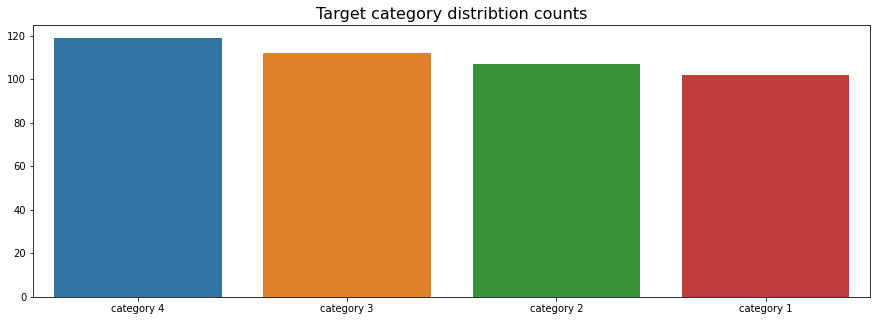

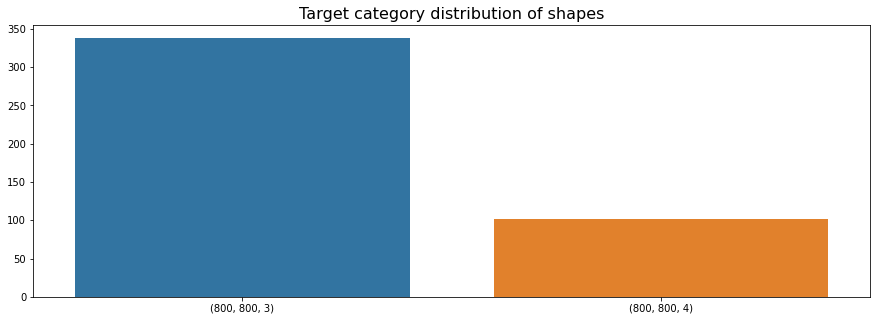

In [ ]:
def distribution_vis(counts_series, label):
  '''
  Target distribution
  '''
  fig = plt.figure(figsize = (15,5))
  sns.barplot(x = counts_series.index, y = counts_series.values)
  plt.title(label, fontsize = 16)

# returns pandas series with classes as keys and count as values for train dataset
target_counts_train = img_df_train['Label'].value_counts()

# shape analysis for train
shape_counts_train = img_df_train['Shape'].value_counts()

# visualize target distribution for labels
distribution_vis(target_counts_train, label = 'Target category distribtion counts')

# visualize shapes distribution for image shapes
distribution_vis(shape_counts_train, label = 'Target category distribution of shapes')

* The data corresonding to 4 categories are imbalanced**
* Some of images are of 4 channels having all images of resolutions (800,800)

**Train Image category-wise Shapes EDA**

Image shape comparison between different categories 

Shape          Label     
(800, 800, 3)  category 4    119
               category 3    112
               category 2    107
(800, 800, 4)  category 1    102
dtype: int64



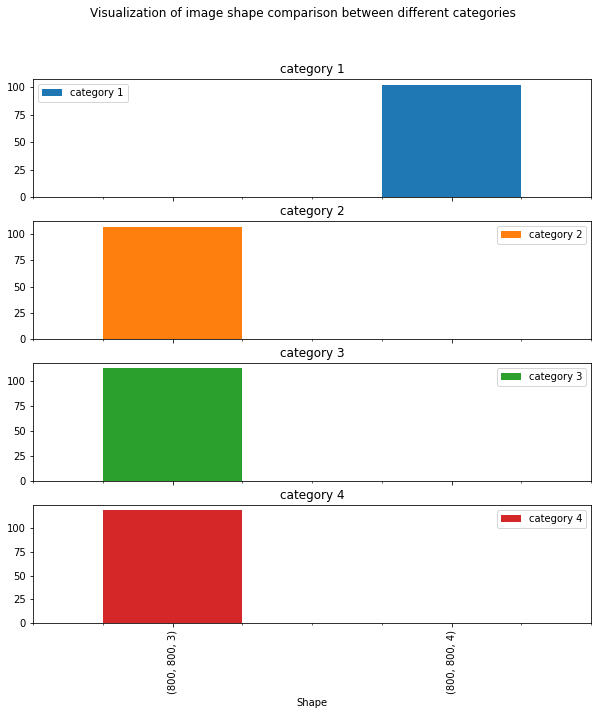

In [ ]:
level_shape_df = img_df_train[['Shape', 'Label']].value_counts()
print(f'Image shape comparison between different categories \n\n{level_shape_df}\n')

# plotting the multi-index dataframe's hist() plot, where label, and shape are two index
level_shape_df.unstack(level = 1).plot(kind = 'bar', subplots = True, figsize = (10,10), 
                                       title = 'Visualization of image shape comparison between different categories')
plt.show()

**We found here that all images corresponding to category 1 are of 4 channels**

#### **Experiment on 4 channel to 3 channel image conversion**

Function to rescale images

In [106]:
def img_rescale(img_path):
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  # in case grayscale image len(img.shape) == 2  
  if len(img.shape)>2 and img.shape[2]==4:
    # convert the image from RGBA2RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
  # convert BGR to RGB
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # convert to float32
  img = img.astype(np.float32)

  # normalize the image, as due to interpolation the pixel value may not lie in the range (0,1)
  # to restrict that we neeed to normalize them so than it can lie within a scale 
  img -= img.min()
  img /= (img.max() - img.min()) 

  return img

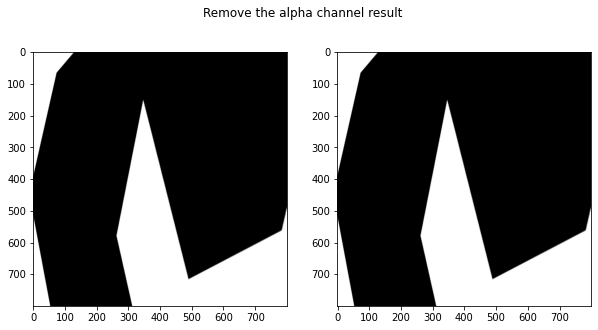

Image dtype before, after removal float32, float32
Image shape before, after removal (800, 800, 4), (800, 800, 3)


In [ ]:
# take sample image of category 1
sample_img_path = '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train/category 1/category 1_original_1000.png_01b3b4fc-dabe-457d-9159-3c2e7eb77785.png'

fig = plt.figure(figsize=(10,5))
fig.suptitle('Remove the alpha channel result')

# original image
img = plt.imread(sample_img_path)
fig.add_subplot(121)
plt.imshow(img)

# after removing alpha channel
img_rgb = img_rescale(sample_img_path)
fig.add_subplot(122)
plt.imshow(img_rgb)

plt.show()

print(f'Image dtype before, after removal {img.dtype}, {img_rgb.dtype}')
print(f'Image shape before, after removal {img.shape}, {img_rgb.shape}')

#### **Removing alpha channel from images of category 1**

Here we will do all the changes on train_copy folder. 

Path: "/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/train_copy/train/category 1"

Run Demo

Before removal shape (800, 800, 3)


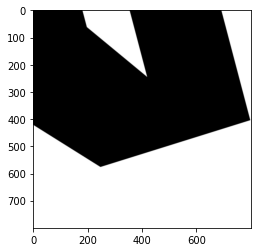

After removal RGB dtype, shape float32, (800, 800, 3)


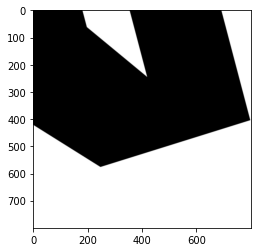

In [ ]:
# taking path of the copy of train images, where we will do the changes
category1_path = '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/train_copy/train/category 1'

def img_conversion(img_path_list):
  for img_path in img_path_list:
    if img_path!='.DS_Store':
      path = os.path.join(category1_path, img_path)
      print(f'Before removal shape {plt.imread(path).shape}')
      plt.imshow(plt.imread(path))
      plt.show()

      # after removing alpha channel
      img_rgb = img_rescale(path)
      #new_path = 'rgb_new.png'
      # save the image with same name
      # imageio helps to write the images keeping 3 channels while saving
      imageio.imwrite(path, img_rgb)
      
      plt.imshow(plt.imread(path))
      print(f'After removal RGB dtype, shape {plt.imread(path).dtype}, {plt.imread(path).shape}')
      plt.show()

# demo
img_conversion(os.listdir(category1_path)[2:3])

Converting all the images corresponding to category 1

In [ ]:
def img_conversion_all(img_path_list):
  for img_path in img_path_list:
    if img_path!='.DS_Store':
      path = os.path.join(category1_path, img_path)
      
      # after removing alpha channel
      img_rgb = img_rescale(path)
      # save the image with same name
      # imageio helps to write the images keeping 3 channels while saving
      imageio.imwrite(path, img_rgb)
      
# demo
img_conversion_all(os.listdir(category1_path))

Fetch the rescaled(after removing alpha channel) images corresponding to category 1

In [ ]:
# train copy path
img_dir_train_copy = '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/train_copy/train'
# fetching label_array, image_array
label_df_train, img_df_train = fetch_img(img_dir_train_copy)

# config target distribution
config.distribution = label_df_train

print(f'\nCategory wise counts in train dataset\n{label_df_train}')
#img_df_train

Geometric directory names list ['/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/train_copy/train/category 1', '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/train_copy/train/category 2', '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/train_copy/train/category 3', '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/train_copy/train/category 4']

[INFO] Loading images ...
[INFO] Processing category 1
[INFO] Processing category 2
[INFO] Processing category 3
[INFO] Processing category 4

Category wise counts in train dataset
  category 1 category 2 category 3 category 4
0        102        107        112        119


**Recheck the shape distribution**

Image shape comparison between different categories 

Shape          Label     
(800, 800, 3)  category 4    119
               category 3    112
               category 2    107
               category 1    102
dtype: int64



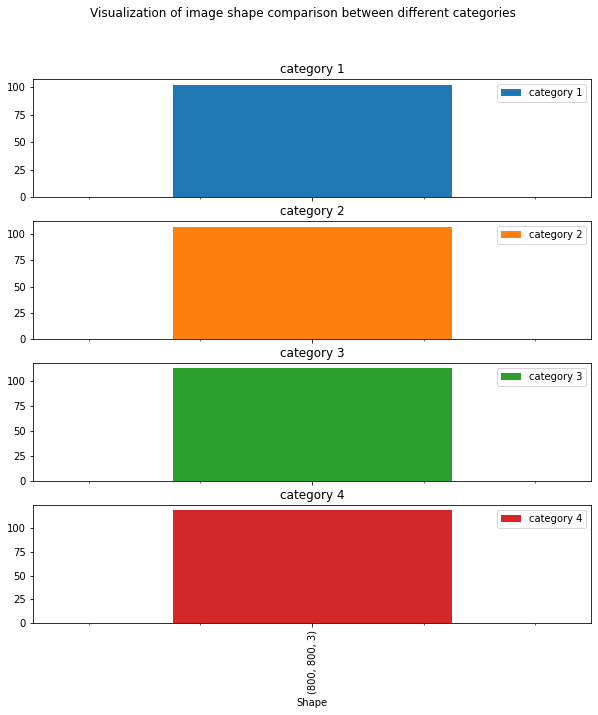

In [ ]:
level_shape_df = img_df_train[['Shape', 'Label']].value_counts()
print(f'Image shape comparison between different categories \n\n{level_shape_df}\n')

# plotting the multi-index dataframe's hist() plot, where label, and shape are two index
level_shape_df.unstack(level = 1).plot(kind = 'bar', subplots = True, figsize = (10,10), 
                                       title = 'Visualization of image shape comparison between different categories')
plt.show()

**We can see all the images shapes are uniform to (800,800,3)**

#### **Data Augmentation**

Demo of data augmentation

In [ ]:
# create demo folder path for augmentation check
demo_path = '/content/demo_path'

# define augmentor object
p = Augmentor.Pipeline(source_directory=demo_path, output_directory='/content/aug_path')
# define methods of image augmentation
p.rotate90(probability = 0.5)
#p.rotate(probability = 0.5)
p.rotate180(probability = 0.5)
p.flip_left_right(probability=0.3)
p.flip_top_bottom(probability=0.8)
#p.flip_random(probability=0.5)

p.sample(5)

Processing <PIL.Image.Image image mode=RGB size=800x800 at 0x7F03D1984A50>: 100%|██████████| 5/5 [00:00<00:00, 26.48 Samples/s]

Initialised with 1 image(s) found.
Output directory set to /content/aug_path.

Original image


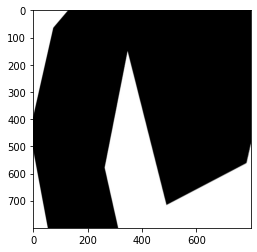

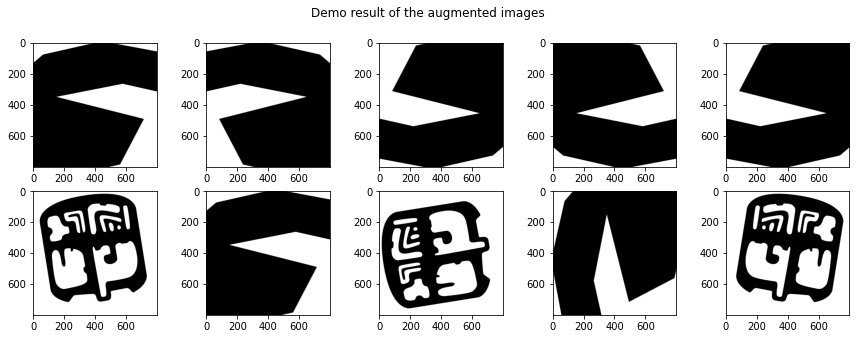

In [ ]:
print('Original image')
plt.imshow(plt.imread('/content/demo_path/category 1_original_1000.png_01b3b4fc-dabe-457d-9159-3c2e7eb77785.png'))
plt.show()

# demo result
fig = plt.figure(figsize=(15,5))
fig.suptitle('Demo result of the augmented images')
i = 0
for img_path in os.listdir('/content/aug_path'):
  if img_path.endswith('.png')==True or img_path.endswith('.PNG')==True: 
    fig.add_subplot(2,5,i+1)
    plt.imshow(plt.imread(os.path.join('/content/aug_path', img_path)))
    i+=1

plt.show()

Augmenting individual image

Original image


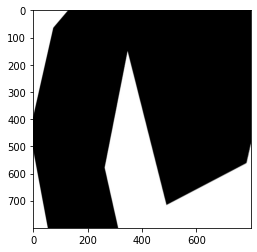

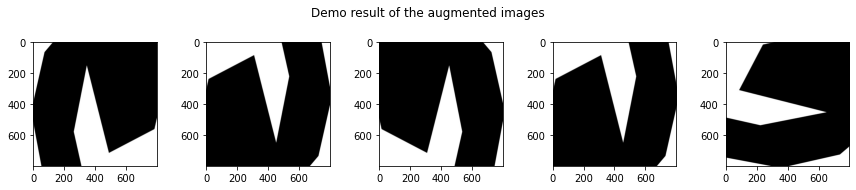

In [ ]:
print('Original image')
plt.imshow(plt.imread('/content/demo_path/category 1_original_1000.png_01b3b4fc-dabe-457d-9159-3c2e7eb77785.png'))
plt.show()

# demo result
fig = plt.figure(figsize=(15,5))
fig.suptitle('Demo result of the augmented images')
i = 0
for img_path in os.listdir('/content/aug_path'):
  if img_path.endswith('.png')==True or img_path.endswith('.PNG')==True: 
    fig.add_subplot(2,5,i+1)
    plt.imshow(plt.imread(os.path.join('/content/aug_path', img_path)))
    i+=1

plt.show()

From above experiment, we are deciding to go for individual image augmentation to make 5 augmented samples for individual images

##### **Augment the images of all 4 categories to a different destination folder**

Create destination folders

In [ ]:
augmented_path = os.path.join('/content/drive/MyDrive/Geometric image classification/Geometric Image Classification', 'aug_dataset')

# create augmented image path
if not os.path.isdir(augmented_path):
  os.mkdir(augmented_path)

# create folders for all the categories inside the augmented path
for category in classifiers:
  cat_path = os.path.join(augmented_path, category)
  if not os.path.isdir(cat_path):
    os.mkdir(cat_path)   

Augment all the images to final samples 600 for each categories

In [ ]:
for copy_path in os.listdir(img_dir_train_copy):
  if copy_path.endswith('.DS_Store')==False and copy_path.endswith('.ipynb_checkpoints')==False:
    src_dir = os.path.join(img_dir_train_copy, copy_path)
    #print(src_dir)
    out_dir = os.path.join(augmented_path, copy_path)
    #print(out_dir)
    # define augmentor object
    p = Augmentor.Pipeline(source_directory=src_dir, output_directory=out_dir)
    
    # define methods of image augmentation
    p.rotate90(probability = 0.5)
    #p.rotate(probability = 0.5)
    p.rotate180(probability = 0.5)
    p.flip_left_right(probability=0.3)
    p.flip_top_bottom(probability=0.8)
    #p.flip_random(probability=0.5)

    p.sample(600)

Executing Pipeline:   0%|          | 0/600 [00:00<?, ? Samples/s]

Initialised with 112 image(s) found.
Output directory set to /content/drive/MyDrive/Geometric image classification/Geometric Image Classification/aug_dataset/category 3.

Processing <PIL.Image.Image image mode=RGB size=800x800 at 0x7F03D18BCAD0>: 100%|██████████| 600/600 [00:23<00:00, 25.66 Samples/s]
Executing Pipeline:   0%|          | 0/600 [00:00<?, ? Samples/s]

Initialised with 102 image(s) found.
Output directory set to /content/drive/MyDrive/Geometric image classification/Geometric Image Classification/aug_dataset/category 1.

Processing <PIL.Image.Image image mode=RGB size=800x800 at 0x7F03D06B12D0>: 100%|██████████| 600/600 [00:22<00:00, 26.29 Samples/s]
Executing Pipeline:   0%|          | 0/600 [00:00<?, ? Samples/s]

Initialised with 119 image(s) found.
Output directory set to /content/drive/MyDrive/Geometric image classification/Geometric Image Classification/aug_dataset/category 4.

Processing <PIL.Image.Image image mode=RGB size=800x800 at 0x7F03D3EC6610>: 100%|██████████| 600/600 [00:23<00:00, 25.14 Samples/s]
Executing Pipeline:   0%|          | 0/600 [00:00<?, ? Samples/s]

Initialised with 107 image(s) found.
Output directory set to /content/drive/MyDrive/Geometric image classification/Geometric Image Classification/aug_dataset/category 2.

Processing <PIL.Image.Image image mode=RGB size=800x800 at 0x7F03D28DBA50>: 100%|██████████| 600/600 [00:25<00:00, 23.29 Samples/s]


**Fetch the augmented images to dataframe**

In [16]:
augmented_path = os.path.join('/content/drive/MyDrive/Geometric image classification/Geometric Image Classification', 'aug_dataset')

# train copy path
#img_dir_train_copy = augmented_path
# fetching label_array, image_array
label_df_train, img_df_train = fetch_img(augmented_path)

# config target distribution
config.distribution = label_df_train

print(f'\nCategory wise counts in train dataset\n{label_df_train}')
img_df_train

Geometric directory names list ['/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/aug_dataset/category 1', '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/aug_dataset/category 2', '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/aug_dataset/category 3', '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/aug_dataset/category 4']

[INFO] Loading images ...
[INFO] Processing category 1
[INFO] Processing category 2
[INFO] Processing category 3
[INFO] Processing category 4

Category wise counts in train dataset
  category 1 category 2 category 3 category 4
0        600        600        600        600


Image  ...       Label
0     /content/drive/MyDrive/Geometric image classif...  ...  category 1
1     /content/drive/MyDrive/Geometric image classif...  ...  category 1
2     /content/drive/MyDrive/Geometric image classif...  ...  category 1
3     /content/drive/MyDrive/Geometric image classif...  ...  category 1
4     /content/drive/MyDrive/Geometric image classif...  ...  category 1
...                                                 ...  ...         ...
2395  /content/drive/MyDrive/Geometric image classif...  ...  category 4
2396  /content/drive/MyDrive/Geometric image classif...  ...  category 4
2397  /content/drive/MyDrive/Geometric image classif...  ...  category 4
2398  /content/drive/MyDrive/Geometric image classif...  ...  category 4
2399  /content/drive/MyDrive/Geometric image classif...  ...  category 4

[2400 rows x 3 columns]

**Saving the fetched train image info to train.csv**

In [17]:
%cd /content/
# save to train csv
img_df_train.to_csv(os.path.join('/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2','data_df.csv'))

# config img_df
config.img_df = img_df_train

/content


#### **Train-Validation-Test Split**

We are taking train, valid, test ratio as - [0.95:0.10]

In [18]:
# validation split
val_ratio = 0.10
# test split
#test_ratio = 0.5

# image_ids
img_ids = img_df_train.loc[:,'Image']

# image_ids
label_ids = img_df_train.loc[:,'Label']

**Defining train, validation dataframe**

In [19]:
# train df
train_df = pd.DataFrame(columns=['Image','Label'])
# validation main df
#valid_main_df = pd.DataFrame(columns=['Image','Label'])
# validation df
valid_df = pd.DataFrame(columns=['Image','Label'])
# test df
#test_df = pd.DataFrame(columns=['Image','Label'])

**Defining Train, Valid, Test split**

Train-Valid_main split

In [20]:
# without shuffling startification is not possible
train_df['Image'], valid_df['Image'], train_df['Label'], valid_df['Label'] = train_test_split(img_ids, label_ids,
                                                                                                        test_size = val_ratio,
                                                                                                        random_state = 28,
                                                                                                        stratify = label_ids,
                                                                                                        shuffle = True
                                                                                                        )

In [21]:
print(f'Train dataframe shape {train_df.shape}')
print(f'Validation dataframe shape {valid_df.shape}')

Train dataframe shape (2160, 2)
Validation dataframe shape (240, 2)


**Startification Check**

Defining visualization function for stratified train valid split

In [22]:
# startified vis func
def distribution_vis_check(train, valid):
  '''
  Target distribution
  '''
  xdf = [train.index, valid.index]
  ydf = [train.values, valid.values]
  label = ['Train Distribution', 'Validation Distribution']
  fig = plt.figure(figsize=(20,5))
  for i in range(len(xdf)):
    fig.add_subplot(1, len(xdf), i+1)
    sns.barplot(x = xdf[i], y = ydf[i])
    plt.xlabel(label[i], fontsize = 16)

**Stratification result**

In [23]:
print('Startification result-')
print('Train set -\n{}'.format(train_df['Label'].value_counts()))
print('Validation set -\n{}'.format(valid_df['Label'].value_counts()))

Startification result-
Train set -
category 3    540
category 4    540
category 1    540
category 2    540
Name: Label, dtype: int64
Validation set -
category 2    60
category 4    60
category 3    60
category 1    60
Name: Label, dtype: int64


**Startification Distribution Visualize**

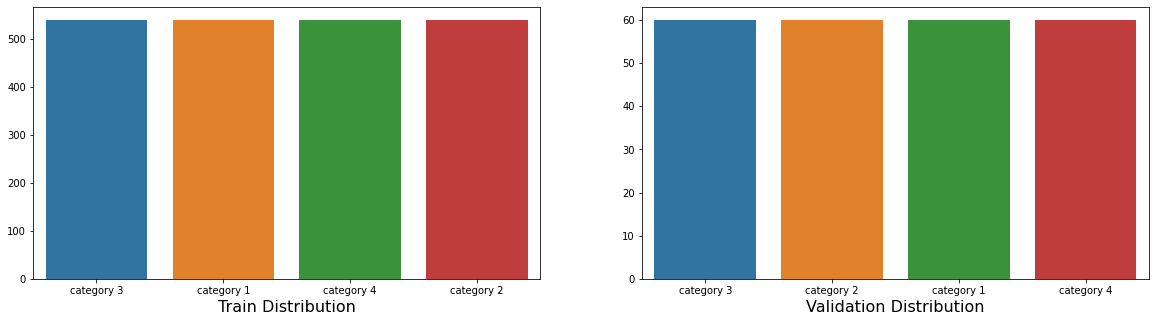

In [ ]:
distribution_vis_check(train_df['Label'].value_counts(), valid_df['Label'].value_counts())

The data is stratified split almost

**Define the classifiers directory**

In [24]:
print(f'Classifiers list {config.classifiers}')

id_list = [i for i in range(len(config.classifiers))]

# labels distionary
config.label_dict = dict(zip(config.classifiers, id_list))

print(f'Classifiers dictionary\n{config.label_dict}')

Classifiers list ['category 1', 'category 2', 'category 3', 'category 4']
Classifiers dictionary
{'category 1': 0, 'category 2': 1, 'category 3': 2, 'category 4': 3}


#### **Image pre-peocessing and data preperation using keras ImageDataGenerator**

* For the flow batch size = 32, shuffle = True, class_mode = Sparse, seed = 1 used, target_size = (256,256), interpolation = 'bicubic', rescale = 1/.255

In [25]:
# define batch size based on which datagen will prepare the data
config.batch_size = 32

# to use sparse categorical cross entropy 
config.class_mode = 'categorical'

# target size to standard (256,256)
config.target_size = (256,256)

# bicubic interpolation used 
config.interpolation = 'bicubic'

In [26]:
config.columns = train_df.columns
print(f'Columns {config.columns}')

Columns Index(['Image', 'Label'], dtype='object')


**Define the function to pre-process the image to keep the image pixel range within 0 to 1 range**

In [27]:
def pre_process(img):
  # normalize the image, as due to interpolation the pixel value may not lie in the range (0,1)
  # to restrict that we neeed to normalize them so than it can lie within a scale 
  img -= img.min()
  img /= (img.max() - img.min()) 

  return img

In [28]:
# creating imagedatagenerator object using keras
datagen = ImageDataGenerator(rotation_range=None,
                                   width_shift_range = None,
                                   height_shift_range = None,
                                   brightness_range = None,
                                   zoom_range = 0.0,
                                   rescale = None,
                                   preprocessing_function = pre_process,
                                   dtype = np.float32,
                                   )

# provide same seed and keyword arguments to the fit and flow methods 
seed = 1

# obtaining images from augmented train dataset and apply augmentation using datagen to create batches
train_generator = datagen.flow_from_dataframe(dataframe = train_df,
                                              directory = augmented_path,
                                              x_col = config.columns[0],
                                              y_col = config.columns[1],
                                              batch_size=config.batch_size,
                                              shuffle=True,
                                              class_mode = config.class_mode,
                                              target_size = config.target_size, 
                                              classes = config.classifiers,
                                              interpolation = config.interpolation
                              )

# obtaining images from validation dataset and apply augmentation using datagen to create batches
valid_generator = datagen.flow_from_dataframe(dataframe = valid_df,
                                              directory = augmented_path,
                                              x_col = config.columns[0],
                                              y_col = config.columns[1],
                                              batch_size=config.batch_size,
                                              shuffle=True,
                                              class_mode = config.class_mode,
                                              target_size = config.target_size, 
                                              classes = config.classifiers,
                                              interpolation = config.interpolation
                              )


Found 2160 validated image filenames belonging to 4 classes.
Found 240 validated image filenames belonging to 4 classes.


**Assertion check for data generation**

In [29]:
assert train_generator.class_indices == valid_generator.class_indices == config.label_dict
assert train_generator.image_shape == valid_generator.image_shape == (256,256,3)
assert train_generator.dtype == valid_generator.dtype == 'float32'

print('Assertion check passed for data generation!')

Assertion check passed for data generation!


In [30]:
def img_label_samples(train_generator, class_count = 4):
  '''
  Fetches 1st sample of each class from 0 to 4
  Along with the class label or id
  Takes total class samples to be visualized 
  Batch count as attributes
  '''
  # total batches in the train datagenerator
  batch_count = len(train_generator)
  # image list initialization
  img_list = []
  # labels list
  labels = []

  for cls in range(class_count):
    for batch in range(batch_count):
      # traversing through image label or class id
      # O-> Batch, 1-> Class(for 1, 0 for image), 2-> Index of each image in the batch(0 to 31)
      for i, j in enumerate(train_generator[batch][1][:]):
        if int(j)==cls:
          img_list.append(train_generator[batch][0][i])
          labels.append(int(j))
          break
      if int(j) == cls:
        break
  return img_list, labels

In [ ]:
# obtain image and label list from train_generator
img_list, labels = img_label_samples(train_generator)
print(f'Image data max {img_list[0].max()}, min {img_list[1].min()}')

Image data max 1.0, min 0.0


**Visualize the generated images using keras imagedatagenerator**

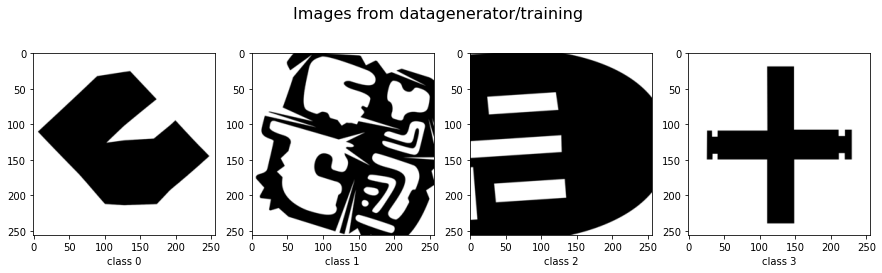

In [ ]:
fig = plt.figure(figsize=(15,4))
fig.suptitle('Images from datagenerator/training', fontsize = 16)
fig.tight_layout()

for i, (img, label) in enumerate(zip(img_list, labels)):
  fig.add_subplot(1,len(img_list), i+1)
  plt.imshow(img)
  plt.xlabel(f'class {label}')

plt.show()

## **CNN Model Building** 

Testing with different pre-trained CNN models using transfer learning and also some custom models training from scratch

In [31]:
# input image shape
config.input_shape = (256,256,3)

# num of classes
config.class_num = 4 #for binary classification

**Load the pre-trained model**(not considered)

1. EfficientNetB2 model

In [ ]:
input_tensor = tf.keras.layers.Input(shape = (256,256,3))

# using effifientnetB2 where the image size (260,260,3) 
efficientnet = tf.keras.applications.EfficientNetB2(
    input_tensor = input_tensor,
    include_top = True, # include top is false as we want only 1 class here
    weights = "imagenet"
)
transfer_model = efficientnet
print('Model weights are loaded!')
#efficientnet.summary()

37437440/37432240 [==============================] - 0s 0us/step
Model weights are loaded!


2. Nasnetmobile(not considered)

In [ ]:
input_tensor = tf.keras.layers.Input(shape = (256,256,3))

# using effifientnetB2 where the image size (260,260,3) 
nasnet = tf.keras.applications.NASNetMobile(
    input_tensor = input_tensor,
    include_top = True, # include top is false as we want only 1 class here
    weights = "imagenet"
)
transfer_model = nasnet
print('Model weights are loaded!')
#transfer_model.summary()

Model weights are loaded!


#### **Transfer Learning**

In [ ]:
x = transfer_model.layers[-2].output
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Dense(1000, activation='relu')(x)
#x = tf.keras.layers.Dense(512, activation='relu')(x)
#x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(class_num, activation='sigmoid')(x)

model = tf.keras.Model(inputs = transfer_model.input, outputs = x)
#model.summary()

**Define training states of the pretrained model training layers**

In [ ]:
# defines whether the layers or which layers will be set for training or freezed
for layer in transfer_model.layers:
  layer.trainable = True

#### **Define a custom base Model**

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0     

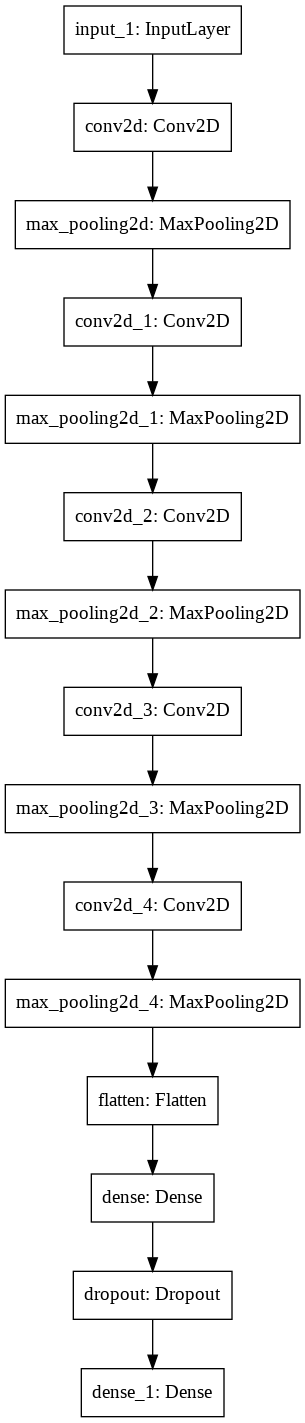

In [32]:
def base_model(input_shape, num_classes):
  inputs = tf.keras.layers.Input(shape = input_shape)

  x = tf.keras.layers.Conv2D(filters = 16, kernel_size=(3,3), activation='relu', strides=(1,1))(inputs)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides=(1,1))(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides=(1,1))(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides=(1,1))(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides=(1,1))(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1000, activation='relu')(x)
  x = tf.keras.layers.Dropout(rate = 0.3)(x)
  output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

  return tf.keras.Model(inputs = inputs, outputs = output)

base_model = base_model(config.input_shape, config.class_num)
base_model.summary()
# save model structure image
plot_model(base_model, to_file = 'cnn_base.png')

## **Configure Model Training**

#### **Define Training metadata**

In [33]:
# learning rate
config.learning_rate = 0.001 # initial lr

# epochs no.
config.epochs = 10

# loss function
config.loss_fn = 'categorical_crossentropy'

# optimizer
config.optim = tf.keras.optimizers.Adam(learning_rate = config.learning_rate)

**Define training metrics**

Define true-positive, false-positive, true-negative, false-negative, precision, recall, area under curve for precision-recall curve

In [34]:
config.METRICS = [
           tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalsePositives(name='fp'),
           tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.FalseNegatives(name='fn'),
           tf.keras.metrics.BinaryAccuracy(name='acc'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]

#### **Define Training steps for train and log to wandb**

**Training metadata**

In [35]:
'''
 Instruction: Initialize everytime before using wandbcallback and run.join()
'''
# initialize wandb with the project
'''
run = wandb.init(project='Geometric_data_classification',
                 config = {
                     "learning_rate": config.learning_rate,
                     "epochs": config.epochs,
                     "batch_size": config.batch_size,
                     "loss_function": config.loss_fn,
                     "architecture": "CNN", 
                     "dataset":"Geometric_logo"
                 })

config_wandb = wandb.config # will be used to configure the experiment
'''
# clearing session
keras.backend.clear_session()

#### **Define Callbacks**

In [36]:
# initially error is too high so starting from LR 1e-01 as the initial LR
# learning rate scheduler to obtain optimum LR
# schedule is exponential decaying LR
config.lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-03/(epoch+1))

# if it observes val_acc is stuck in a plateu, reduces learning_rate by factor 0.2 with patience = 5
config.reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc',
                                                 factor = 0.2,
                                                 patience = 5) 

# model checkpoint for transfer learning model
#filepath_transfer = 'transfer_model_epoch{epoch:02d}-acc {val_acc:0.4f}.hdf5'
#mc_transfer = ModelCheckpoint(filepath = filepath_transfer, monitor='val_acc', save_weights_only=True,mode = 'max', verbose = 1, save_best_only=False)

checkpoint_path = '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/model_checkpoints'
# model checkpoint for base model
config.filepath_base = os.path.join(checkpoint_path, 'base_model_epoch{epoch:02d}-acc {val_acc:0.4f}.hdf5')
config.mc_base = ModelCheckpoint(filepath=config.filepath_base, monitor='val_acc', save_weights_only=True,mode = 'max', verbose = 1, save_best_only=False)

#config.wandb_callback = WandbCallback(save_model=False, monitor='val_loss')

**Callback list for transfer model**

In [ ]:
#callbacks_transfer = [lr_schedule, reduce_lr, mc_transfer, wandb_callback, PlotLossesKeras()]

**Callback list for base model**

In [37]:
config.callbacks_base = [config.lr_schedule, config.reduce_lr, config.mc_base, PlotLossesKeras()]

#### **Model Compile**

In [38]:
# compile the model
base_model.compile(optimizer=config.optim, loss = config.loss_fn, metrics=config.METRICS)
print('Done compiling!')

Done compiling!


## **Model Training**

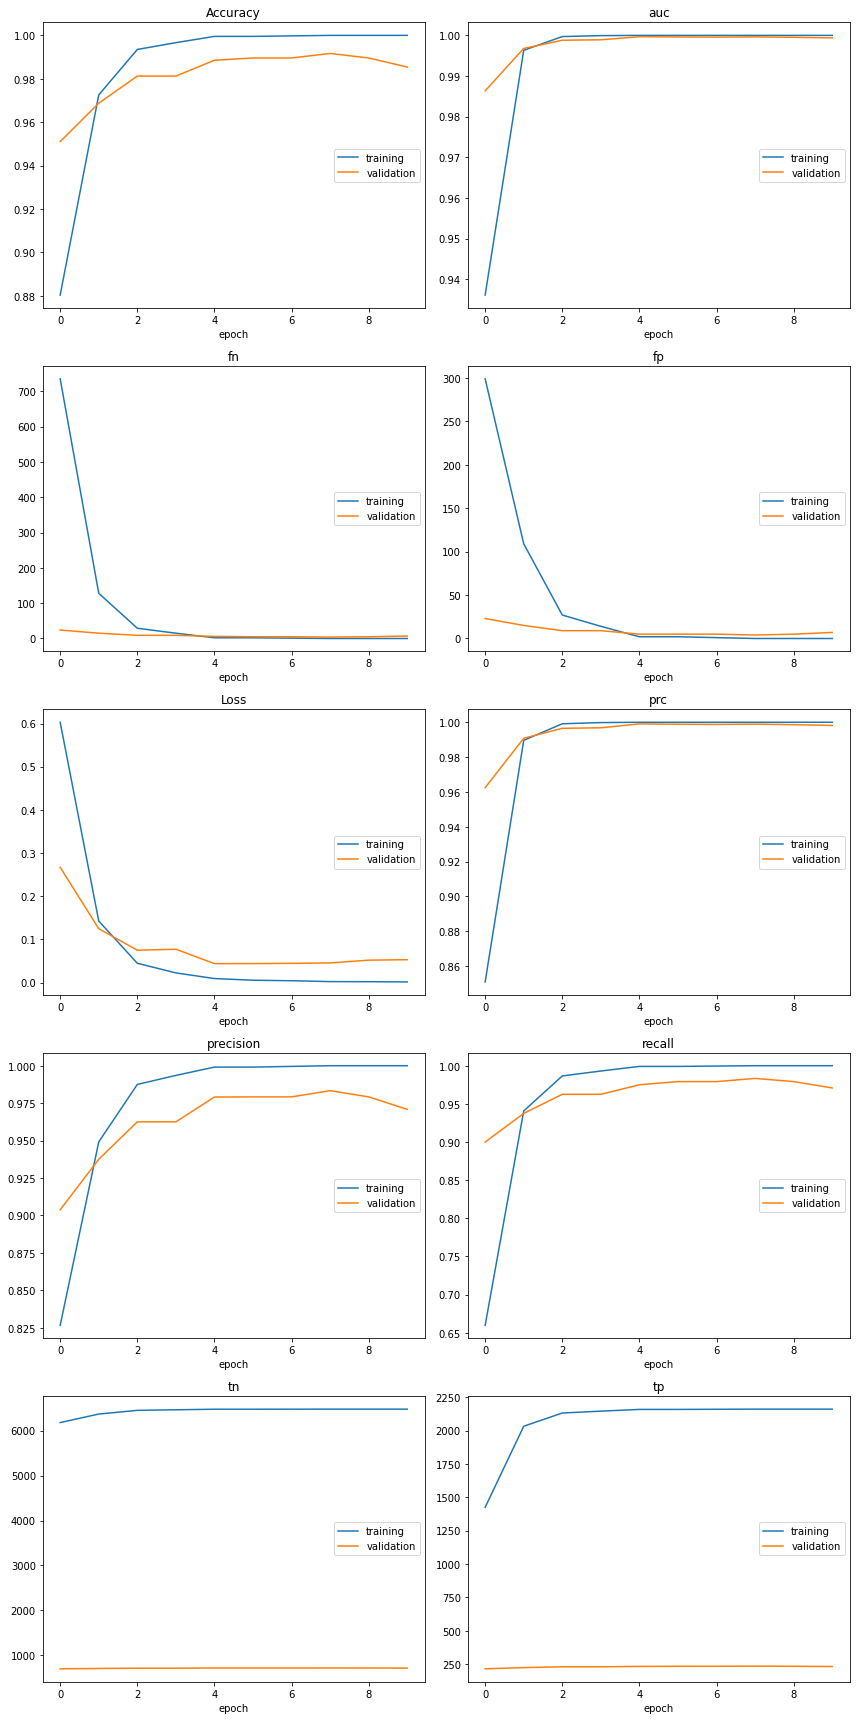

Accuracy
	training         	 (min:    0.880, max:    1.000, cur:    1.000)
	validation       	 (min:    0.951, max:    0.992, cur:    0.985)
auc
	training         	 (min:    0.936, max:    1.000, cur:    1.000)
	validation       	 (min:    0.986, max:    1.000, cur:    0.999)
fn
	training         	 (min:    0.000, max:  735.000, cur:    0.000)
	validation       	 (min:    4.000, max:   24.000, cur:    7.000)
fp
	training         	 (min:    0.000, max:  299.000, cur:    0.000)
	validation       	 (min:    4.000, max:   23.000, cur:    7.000)
Loss
	training         	 (min:    0.001, max:    0.603, cur:    0.001)
	validation       	 (min:    0.044, max:    0.267, cur:    0.053)
prc
	training         	 (min:    0.851, max:    1.000, cur:    1.000)
	validation       	 (min:    0.962, max:    0.999, cur:    0.998)
precision
	training         	 (min:    0.827, max:    1.000, cur:    1.000)
	validation       	 (min:    0.904, max:    0.983, cur:    0.971)
recall
	training         	 (min:    0.

In [39]:
# model history
history = base_model.fit_generator(train_generator, epochs = config.epochs, verbose = 1,
                                  validation_data = valid_generator,  
                                  callbacks = [PlotLossesKeras(), 
                                           config.lr_schedule, 
                                           config.reduce_lr,
                                           config.mc_base])

**Plot the learning rate scheduler**

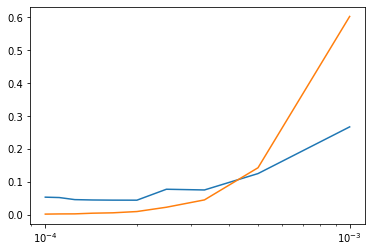

In [43]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.semilogx(history.history['lr'], history.history['loss'])

A very smooth curve for the learning rate with the validation loss and train loss, though at 1e-04, val_loss increases a bit. Thus we are taking the model weights at max_val_accuracy.

## **Model Evaluation**

Best model weight ***"/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/model_checkpoints/base_model_epoch08-acc 0.9917.hdf5"***

In [107]:
config.best_model_weight = '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/model_checkpoints/base_model_epoch08-acc 0.9917.hdf5'
base_model.load_weights(best_model_weight)

####**Define function to plot evaluation metrics**

In [51]:
def plot_metrics(model, x, y):
  # get model predictions
  y_pred = model.predict(x)
  # obtains predictions based on robability
  predictions = np.argmax(y_pred, 1)
  print(f'Classification Report for the model\n{metrics.classification_report(y, predictions)}\n')
  print(f'\nClassification accuracy: {metrics.accuracy_score(y, predictions)*100: 0.2f}\n')
  print('Confusion matrix')
  sns.heatmap(confusion_matrix(y, predictions), annot = True)
  plt.show()

#### **Define ROC curve function**

In [46]:
def plot_roc(name, model, x, y, dataset):
  # get model predictions
  y_pred = model.predict(x)
  # obtains predictions based on probability
  predictions = np.argmax(y_pred, 1)
  tp, fp = metrics.roc_curve(y, predictions)

  plt.plot(100*fp, 10*tp, label = name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([0, 450])
  plt.ylim([0,450])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')


**Evaluate the model using validation data using classification report, confusion matrix**

Iterating over valid_generator to list out all the validation images, labels

In [97]:
val_images = []
val_labels = []

val_batch_count = len(valid_generator)
for batch in range(val_batch_count):
      # traversing through image label or class id
      # O-> Batch, 1-> Class(for 1, 0 for image), 2-> Index of each image in the batch(0 to 31)
      for i, j in enumerate(valid_generator[batch][1][:]):
        #print(valid_generator[batch][0][j].shape)
        val_images.append(valid_generator[batch][0][i])
        val_labels.append(j)
    

**Evaluation**

Shape of val_images, labels (240, 256, 256, 3), (240,)
Classification Report for the model
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.98      0.97      0.97        60
           2       0.98      0.98      0.98        60
           3       0.98      0.98      0.98        60

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240



Classification accuracy:  98.33

Confusion matrix


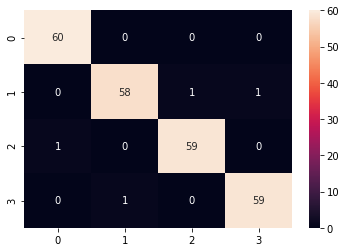

In [102]:
val_images = np.array(val_images)
#val_labels = np.argmax(np.array(val_labels), 1)
print(f'Shape of val_images, labels {val_images.shape}, {val_labels.shape}')

# evaluate the classification report, confusion metrics
plot_metrics(base_model, val_images, val_labels)

## **Model Testing**

Testing the model using test data and record the result to csv

In [108]:
def fetch_test_img(img_dir):
  classifiers_path = os.listdir(img_dir)
  #print(f'Geometric directory names list {classifiers_path}')
  # image array list
  image_list = []
  
  try:
    print('\n[INFO] Loading images ...')
    for category_sample in  classifiers_path:
      category_sample_path = os.path.join(img_dir, category_sample)
      if category_sample_path.endswith(".png") == True or category_sample_path.endswith(".PNG") == True:
        img = img_rescale(category_sample_path)
        img = tf.keras.preprocessing.image.smart_resize(img, size=(256,256), interpolation='bicubic')
        # normalize the image, as due to interpolation the pixel value may not lie in the range (0,1)
        # to restrict that we neeed to normalize them so than it can lie within a scale 
        img -= img.min()
        img /= (img.max() - img.min()) 
        image_list.append(img)
    print('Done loading!')    
    return image_list
      
  except Exception as e:
    print(f'Error {e}')
    return None

Fetch test images

In [109]:
img_list = fetch_test_img('/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/test')


[INFO] Loading images ...
Done loading!


In [114]:
# converting to numpy array
test_array = np.array(img_list)
print(f'Test image array shape {test_array.shape}')
result = base_model.predict(test_array)*100

Test image array shape (30, 256, 256, 3)


In [116]:
np.argmax(result[0])
result[0].max()

99.986855

#### **Visualize Model Result**

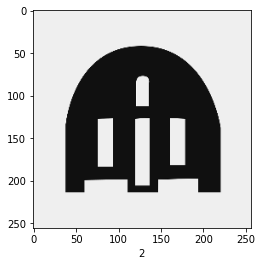

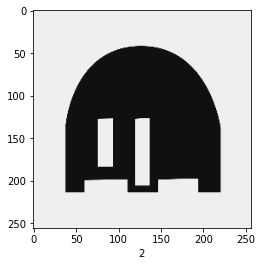

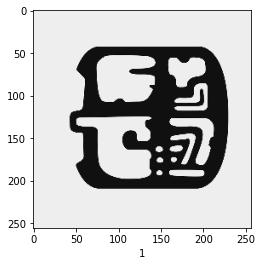

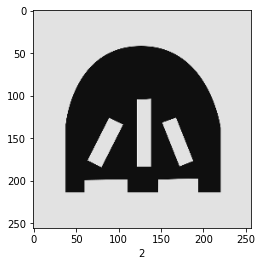

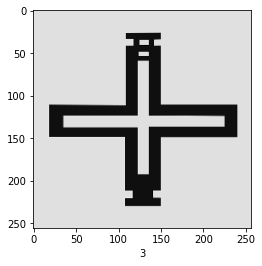

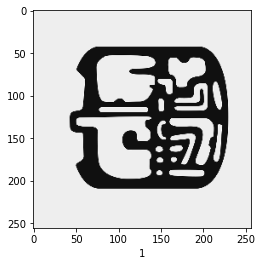

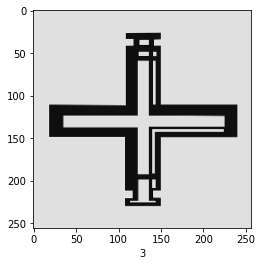

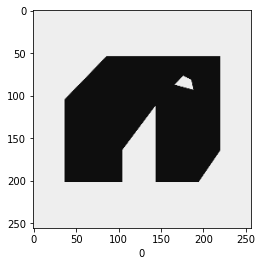

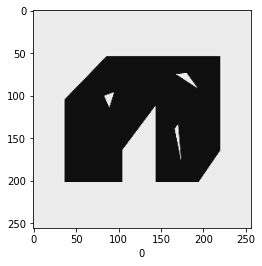

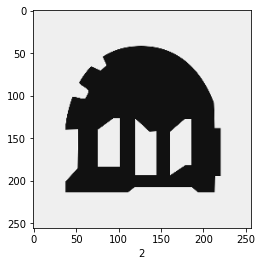

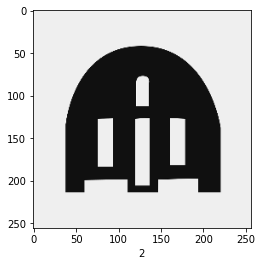

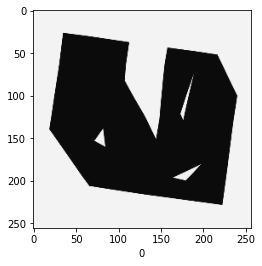

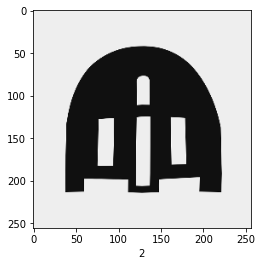

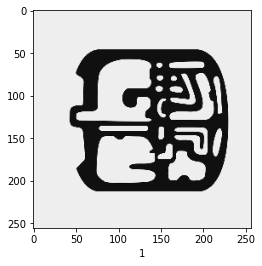

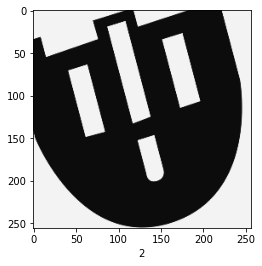

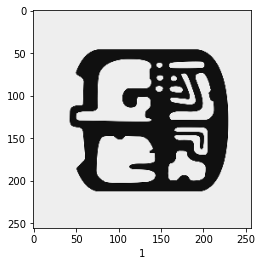

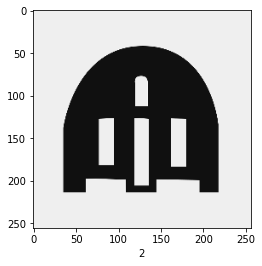

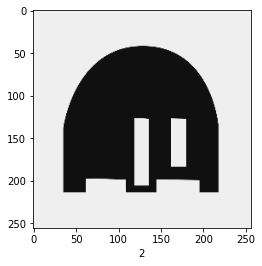

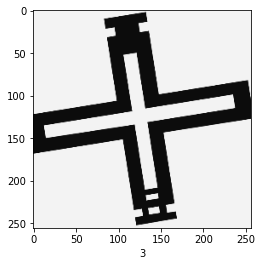

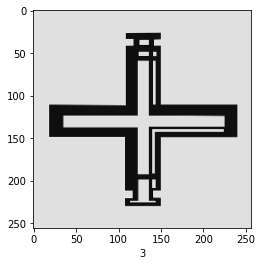

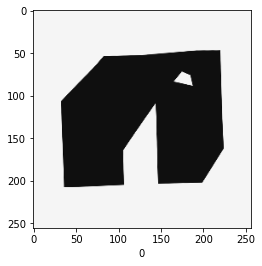

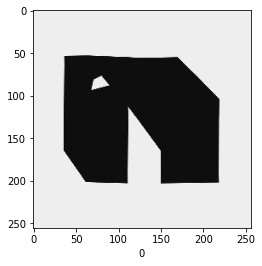

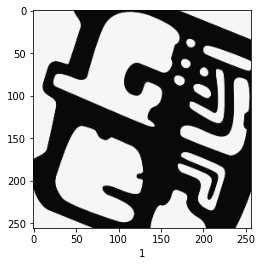

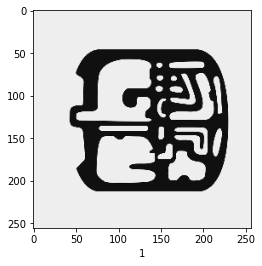

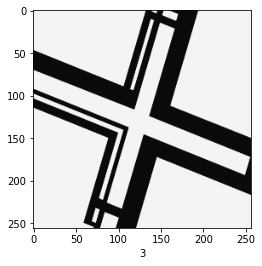

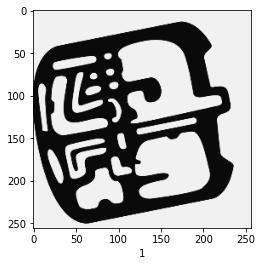

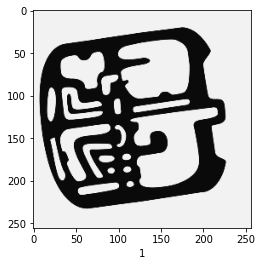

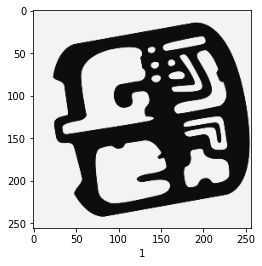

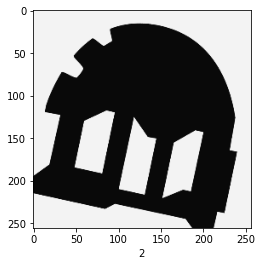

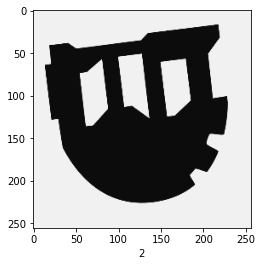

In [ ]:
fig = 
for i, img in enumerate(test_array):
  plt.imshow(img)
  plt.xlabel(result[i])

**Algos for evaluation**

1. **GradCAM:** Visualizing the CNN last layers using Gradient Class Activation Map to understand the portion in the image, where the CNN is looking for classification.

  [Reference](https://keras.io/examples/vision/grad_cam/), Couresera CV week 4.

2. **Saliency Map:** Saliency Map helps to reprsent to pixels of the image to a different domain, thus from saliency map it's better to understand which pixels contributed to that classiification. 

  a. [Coursera Advanced CV week 4](https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow/supplement/M1Td3/reference-gradcam)
  
  b. [Saliency Notebook, keras_vis detailed implementation guide](https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb)

Note: 
[Opencv Colormap guide](https://docs.opencv.org/master/d3/d50/group__imgproc__colormap.html)


## **Visualizing GadCAM**

In [ ]:
# implementing gradcam
def make_gradcam_heatmap(img_array, model, layer_name = None, pred_index=None):
    # if layer name is not given considering the last layer then
    last_conv_layer_name = layer_name
    if last_conv_layer_name == None:
      for layer in reversed(model.layers):
      #for layer in model.layers[:10]:
        if len(layer.output_shape) == 4:
          last_conv_layer_name = layer.name

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, save = None, cam_path=None, alpha=0.7):
    # alpha defines the percentage of overlay, alpha reduces the output will be more close to actual
    # Load the original image
    #img = keras.preprocessing.image.load_img(img_path)
    #img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    #fig = plt.figure(figsize=(10,10))
    #plt.imshow(superimposed_img)

    # Save the superimposed image if save!=None
    if save!=None:
      superimposed_img.save(cam_path)
    return superimposed_img

    # Display Grad CAM
    #display(Image(cam_path))



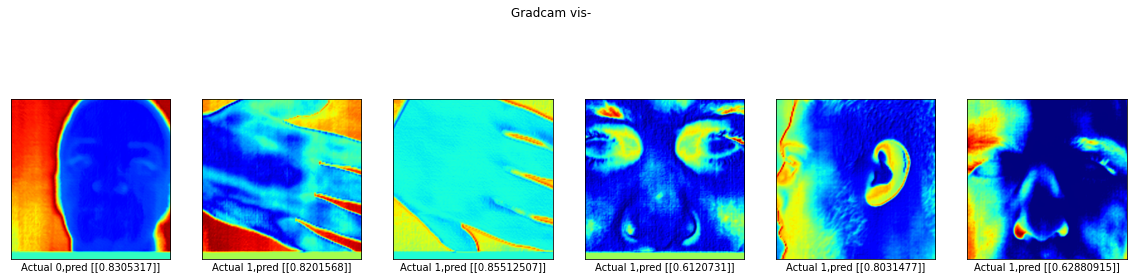

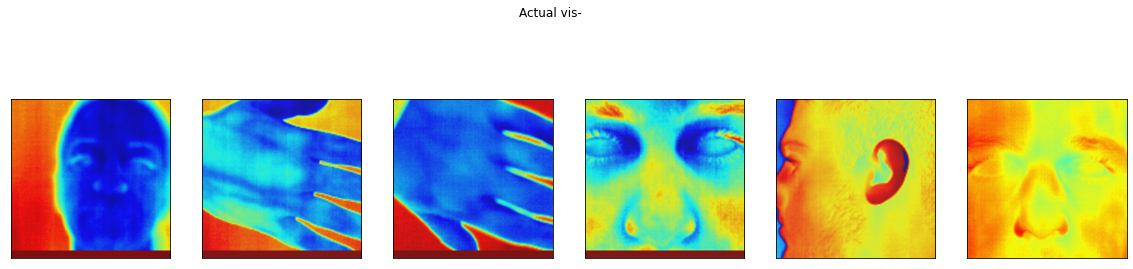

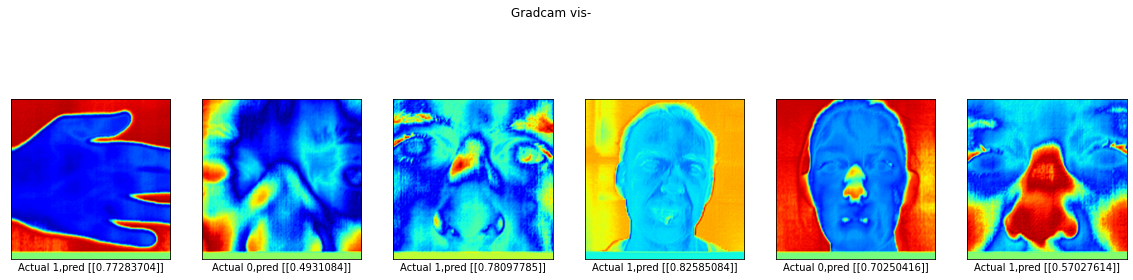

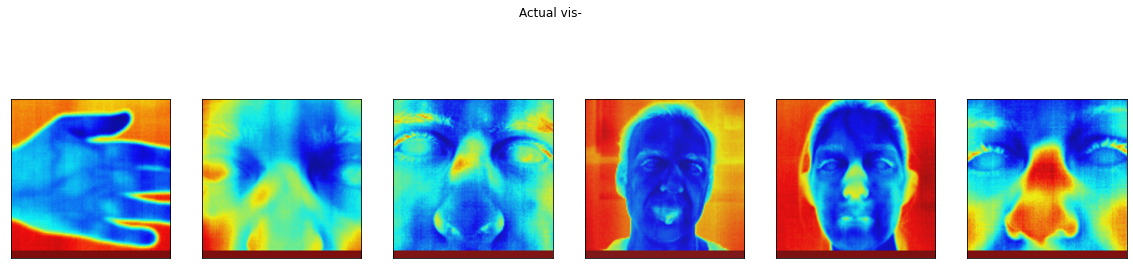

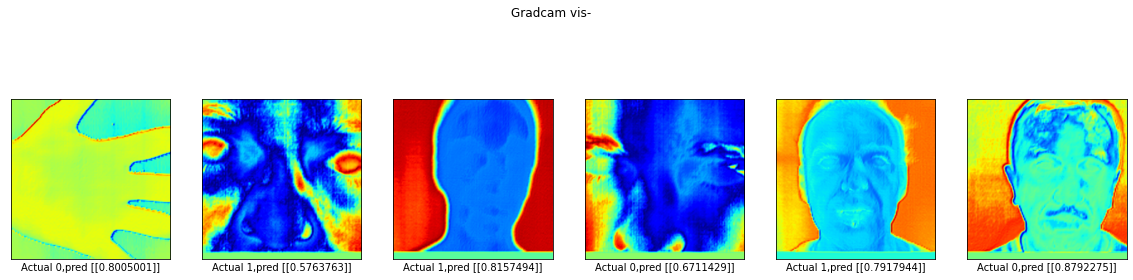

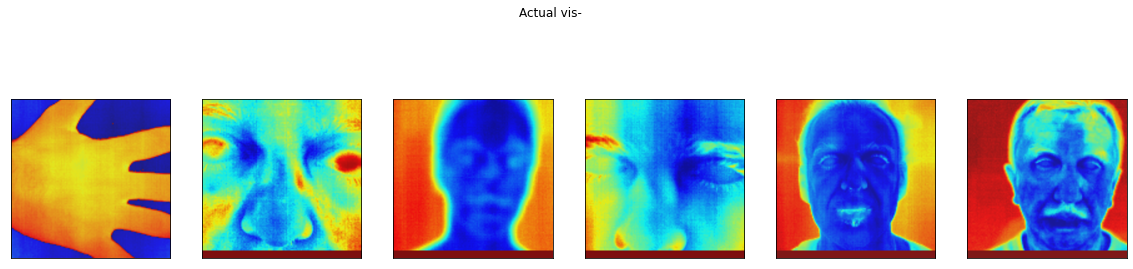

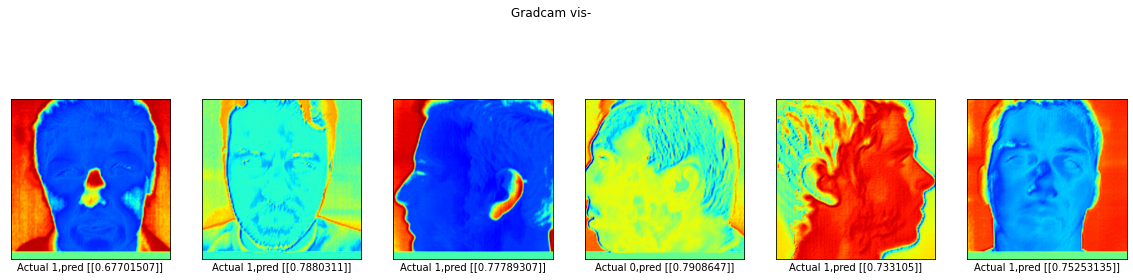

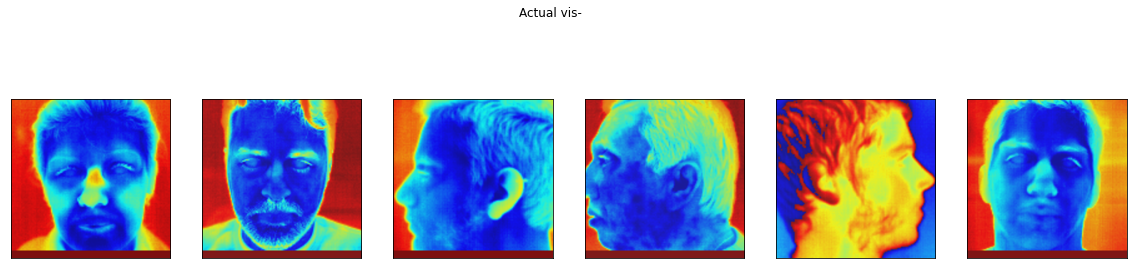

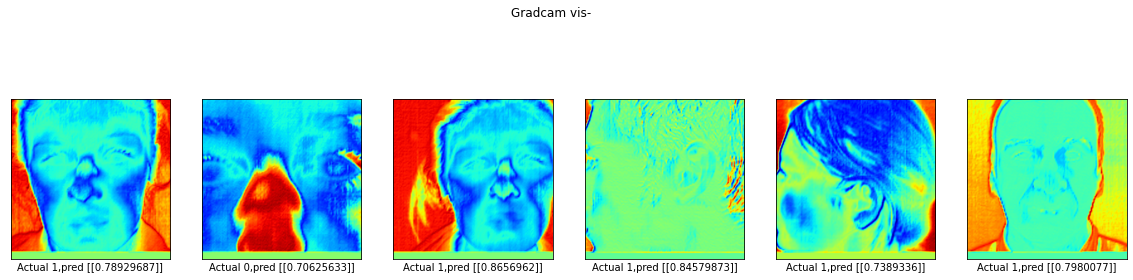

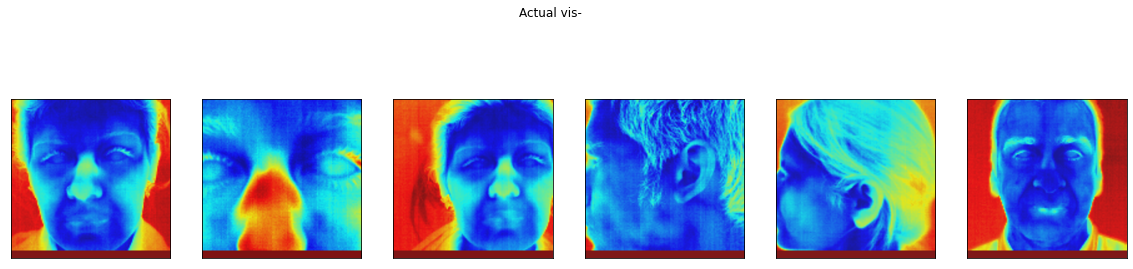

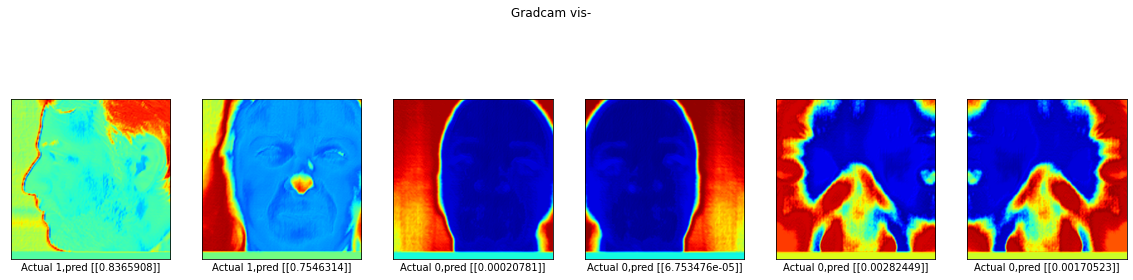

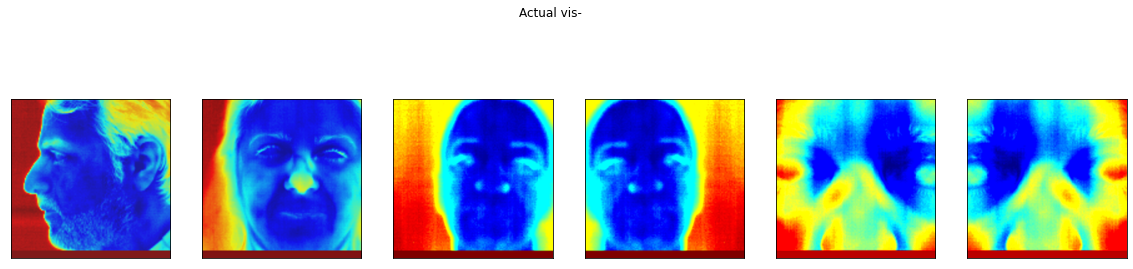

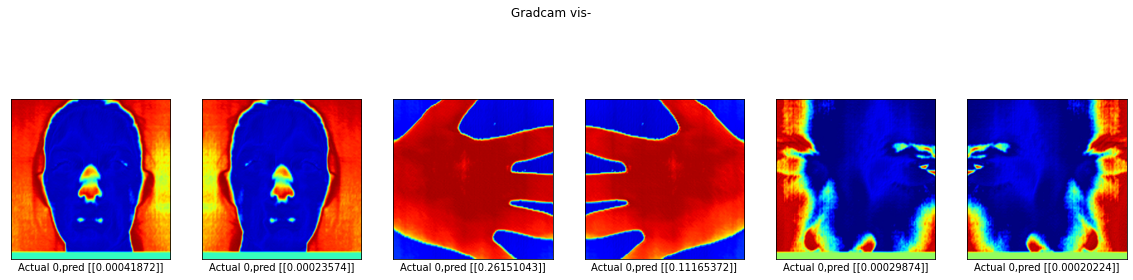

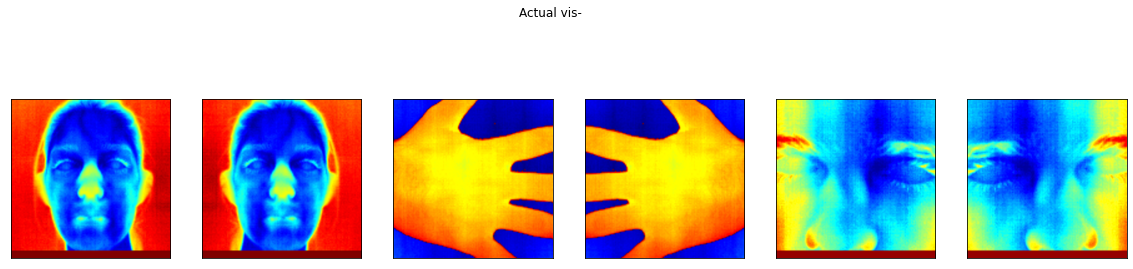

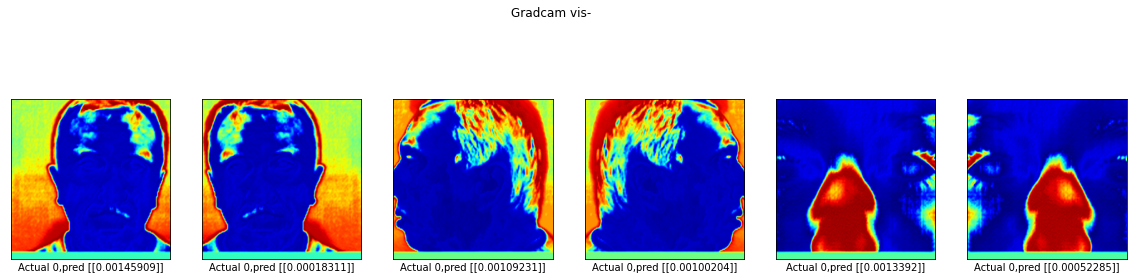

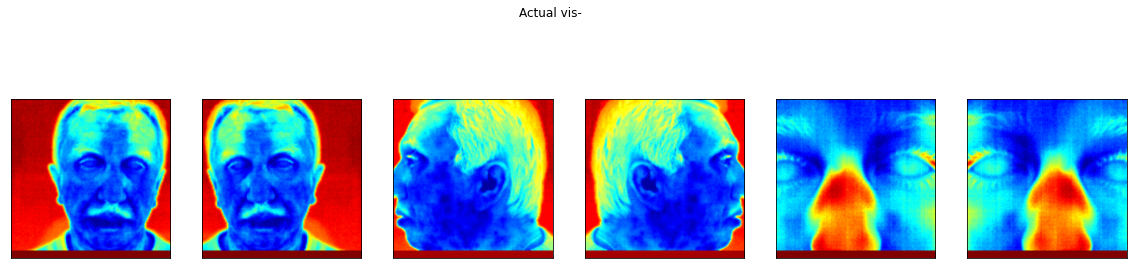

In [ ]:
col_idx = []
for i in range(len(val_aug_imgs)):  
  #col_idx.append(i)
  col_idx.append(i)
  #print(col_idx)
  #print(i%6)
  if (i+1)%6 ==0:
    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    fig.suptitle('Gradcam vis-')
    for a,j in enumerate(col_idx):
      #fig.suptitle('GradCAM Visualization', fontsize = 18)
      #plt.tight_layout()
      img  = np.expand_dims(val_aug_imgs[j], axis = 0)
      hm = make_gradcam_heatmap(img, logged_model, layer_name = None, pred_index=None)
      si = save_and_display_gradcam(img.reshape(256,256,3), hm, save = None, cam_path=None, alpha=0.7)
      fig.add_subplot(1,6,a+1)
      plt.imshow(si)
      plt.xlabel(f'Actual {val_aug_labels[j]},pred {logged_model(img)}')
      plt.xticks([])
      plt.yticks([])
      #col_idx.append(i)
    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    fig.suptitle('Actual vis-')
    for a,j in enumerate(col_idx):
      fig.add_subplot(1,6,a+1)
      plt.imshow(val_aug_imgs[j])
      plt.xticks([])
      plt.yticks([])
      #col_idx.append(i)
    col_idx = []
    
      #fig.add_subplot(,6,i+6+1)
  #plt.imshow(val_aug_imgs[i])
#plt.xlabel(f'actual-{val_aug_labels[i]}, predicted- {logged_model.predict(img)}')
plt.show()